Copyright Preferred Computational Chemistry as contributors to Matlantis contrib project
# [JP] エポキシ樹脂（Bisphenol-A dimer diglycidyl ether）の熱分解シミュレーション
- エポキシ樹脂の熱分解反応は、プラスチックリサイクルのプロセス設計において重要です。通常、ポリマー分子の熱分解は高温で進行し、様々な小分子が生成されます。このような反応過程を扱う方法として、反応力場（ReaxFF）を用いた古典分子動力学（MD）シミュレーションが広く用いられています。これにより、分解反応を詳細に解析することが可能です。一方、ReaxFFは力場の作成が難しいという課題があります。そこで、学習済みの汎用ポテンシャルであるPFPを用いて同様の計算を行い、結果の検証を行いました（HPに公開済の事例から、PFPのバージョンと分子構造が変更されています）。  
https://matlantis.com/calculation/thermal-decomposition-of-epoxy-molecules  

- モデル化合物: Bisphenol-A dimer diglycidyl ether (formula: C<sub>39</sub>H<sub>44</sub>O<sub>7</sub>)  
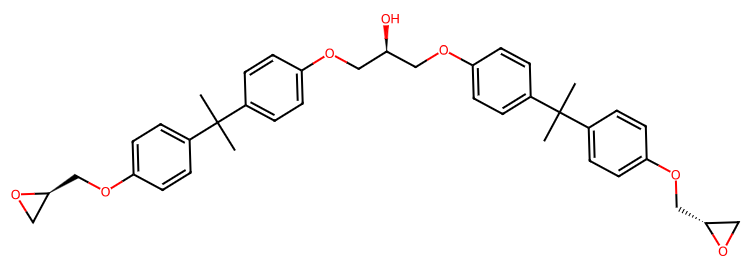
- reaxFFを使用したオリジナルの報告（Z. Diao et al., <I>Journal of Analytical and Applied Pyrolysis</I> <B>2013</B>, <I>104</I>, 618.）  
https://www.sciencedirect.com/science/article/abs/pii/S016523701300096X?via%3Dihub

- 計算の流れ  
1) ライブラリの読み込み  
2) 系の作成  
    - エポキシ樹脂モデルの読み込み・構造最適化
    - エポキシ樹脂モデル15分子の凝集構造作成
3) 熱分解シミュレーション  
    - 昇温速度違い（100, 250, 500 K/ps で 300 K から 2300 K まで）
    - 到達温度違い（500 ps/K で 300 K から 2800, 3300, 4300 K まで）
4) トラジェクトリー解析  
    - 昇温速度違い（元論文 Fig. 4）
    - 到達温度違い（元論文 Fig. 5）
    
# [EN] Simulations of epoxy resin (Bisphenol-A dimer diglycidyl ether) pyrolysis
- Thermal decomposition of epoxy resin is crucial in the design of plastic recycling processes. Typically, polymer molecules decompose into various small molecules at high temperatures. Such reaction processes can be simulated using classical molecular dynamics (MD) with a reactive force field (ReaxFF), which allows detailed analysis of decomposition reactions. However, fitting the force field parameters of ReaxFF is difficult. To address this, we have performed calculations using PFP, a pre-trained universal potential, and compared the results with ReaxFF (the PFP version and molecular structure have been changed from the example on the PFCC website.).  
https://matlantis.com/calculation/thermal-decomposition-of-epoxy-molecules  

- Model compound: Bisphenol-A dimer diglycidyl ether (formula: C<sub>39</sub>H<sub>44</sub>O<sub>7</sub>)  
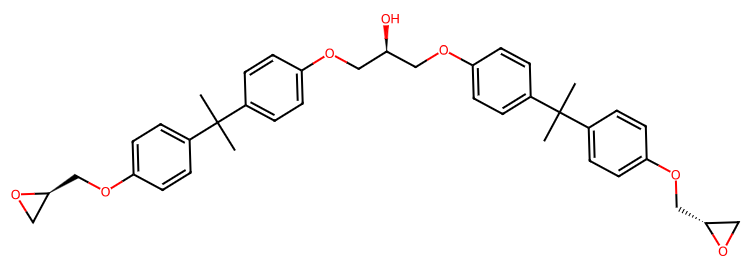
- Original report by using reaxFF（Z. Diao et al., <I>Journal of Analytical and Applied Pyrolysis</I> <B>2013</B>, <I>104</I>, 618.）  
https://www.sciencedirect.com/science/article/abs/pii/S016523701300096X?via%3Dihub

- Calculation flow  
1) Library import  
2) Target system construction  
    - Reading a model epoxy structure followed by geometry optimizations
    - Constructing a condensed structure consisted of 15 model epoxy molcules
3) Pyrolysis simulations
    - Different heating rates（from 300 K to 2300 K by 100, 250, and 500 K/ps）
    - Different target temperatures（from 300 K to 2800, 3300, 4300 K by 500 K/ps）
4) Trajectory analysis
    - Different heating rates (Fig. 4 in the original paper)
    - Different target temperatures (Fig. 5 in the original paper)

## 1. [JP]ライブラリの読み込み / [EN]Library import

In [ ]:
import os

In [1]:
## PFP-API
from pfp_api_client import Estimator, ASECalculator

## Matlantis Features
from matlantis_features.utils.calculators import pfp_estimator_fn
from matlantis_features.atoms import MatlantisAtoms
from matlantis_features.features.common.opt import FireLBFGSASEOptFeature
from matlantis_features.features.md import (ASEMDSystem, MDFeature, MDExtensionBase,
                                            NVTBerendsenIntegrator, NPTIntegrator, NPTBerendsenIntegrator)
from matlantis_features.features.md.md_extensions import TemperatureScheduler

## PFCC_extras
from pfcc_extras.liquidgenerator.liquid_generator import LiquidGenerator
from pfcc_extras.structure.molecule import get_mol_list
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.connectivity import exists_colliding_atom

## ASE
from ase import units
from ase.io import read, write, Trajectory
from ase.optimize import LBFGS, FIRE
from ase.md import MDLogger
from ase.md.nptberendsen import NPTBerendsen
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary

## Python General
from collections import Counter
from joblib import Parallel, delayed
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from time import perf_counter

In [2]:
## PFP model_version & calc_mode
model_version = "v6.0.0"
calc_mode = "CRYSTAL_U0_PLUS_D3"
method = 'v6cU0d3'

## set PFP calculator
estimator = Estimator(model_version=model_version, calc_mode=calc_mode)
calculator = ASECalculator(estimator)

## set pfp_estimator_fn for matlantis-feature
estimator_fn = pfp_estimator_fn(model_version=model_version, calc_mode=calc_mode)

## 2. [JP]系の作成
- エポキシ樹脂のモデル:  
(<I>r</I>)-1-(4-(2-(4-((<I>R</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)-3-(4-(2-(4-((<I>S</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)propan-2-ol  
https://pubchem.ncbi.nlm.nih.gov/compound/14367528 (立体化学の情報なし)
- モデル構造はAvogadro2を使用、立体化学を考慮して作成
- pfcc_extras 内の LiquidGenerator (Torch version)を使用して、凝集構造作成（<B>pfcc_extrasのインストールが必要</B>）

## 2. [EN]Target system construction
- Epoxy resin model:  
(<I>r</I>)-1-(4-(2-(4-((<I>R</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)-3-(4-(2-(4-((<I>S</I>)-oxiran-2-ylmethoxy)phenyl)propan-2-yl)phenoxy)propan-2-ol  
https://pubchem.ncbi.nlm.nih.gov/compound/14367528 (No stereochemistry available)
- The model structure including stereochemistries was constructed by using Avogadro2.
- A condensed system was obtained by using LiquidGenerator (Torch version) in "pfcc_extras" (<B>installtion of pfcc_extras is required</B>).

### [JP]エポキシ樹脂モデルの読み込み・構造最適化 / [EN]Reading a model epoxy structure & geometry optimizations

In [3]:
## read the epoxy structure ('BisphenolA-dimer-diglycidyl-ether.xyz')
atoms_epoxy = read('./input/BisphenolA-dimer-diglycidyl-ether.xyz')
view_ngl(atoms_epoxy, representations=['ball+stick'])

In [4]:
## rough optimization
dirout = 'output'
fname = f'C39H44O7_opt_{method}'
os.makedirs(dirout, exist_ok=True)

atoms_epoxy.calc = calculator
opt = FIRE(atoms_epoxy, logfile=f'{dirout}/{fname}.log', trajectory=f'{dirout}/{fname}.traj')
opt.run(fmax=0.01)

True

### [JP]エポキシ樹脂モデル15分子の凝集構造作成
- 元論文（31.7×22.0×22.6 Å<sup>3</sup>, 1.0 g cm<sup>-3</sup>）に近い緩和構造を作成
- x:y:z = 3:2:2 となるように初期構造セルを設定し, LiquidGeneratorで初期凝集構造作成
- セル長比を維持しつつNPT-MDで平衡化
- NVT-MDによる平衡化

### [EN]Constructing a condensed structure consisted of 15 model epoxy molcules
- Target condensed structure: 31.7×22.0×22.6 Å<sup>3</sup>, 1.0 g cm<sup>-3</sup> (original paper)
- Structure construction by using "LiquidGenerator" with an initial cell setting x:y:z = 3:2:2
- NPT-MD equilibration at 300 K and 1 bar with the fixed cell length ratios
- NVT-MD equilibration at 300 K

In [5]:
# Packing epoxy mols. into a periodic box with x:y:z = 3:2:2
## LiquidGenerator Torch ver.
n_mol = 15
a_unit = 14.5
params = {
    "cell": [[a_unit*3,0,0], [0,a_unit*2,0], [0,0,a_unit*2]],  ## cell format for Torch ver.
    "composition": [atoms_epoxy] * n_mol,
    "epochs": 100
}

## run LiquidGenerator (~5 min.)
generator = LiquidGenerator("torch", **params)
atoms_agg = generator.run()

step  score  cell_x  cell_y  cell_z


/home/jovyan/.py39/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


   0   28215.98 43.50 29.00 29.00
   1   27910.40 43.50 29.00 29.00
   2   28146.26 43.50 29.00 29.00
   3   27022.24 43.50 29.00 29.00
   4   26758.96 43.50 29.00 29.00
   5   27441.61 43.50 29.00 29.00
   6   27487.13 43.50 29.00 29.00
   7   27210.45 43.50 29.00 29.00
   8   27503.83 43.50 29.00 29.00
   9   27405.76 43.50 29.00 29.00
  10   27085.61 43.50 29.00 29.00
  11   26512.78 43.50 29.00 29.00
  12   26004.75 43.50 29.00 29.00
  13   25651.72 43.50 29.00 29.00
  14   25611.56 43.50 29.00 29.00
  15   25528.54 43.50 29.00 29.00
  16   25514.75 43.50 29.00 29.00
  17   25229.21 43.50 29.00 29.00
  18   25369.65 43.50 29.00 29.00
  19   25092.83 43.50 29.00 29.00
  20   24996.01 43.50 29.00 29.00
  21   24948.09 43.50 29.00 29.00
  22   24833.09 43.50 29.00 29.00
  23   24844.09 43.50 29.00 29.00
  24   24777.93 43.50 29.00 29.00
  25   24740.56 43.50 29.00 29.00
  26   24757.24 43.50 29.00 29.00
  27   24748.17 43.50 29.00 29.00
  28   24869.59 43.50 29.00 29.00
  29   24711.1

In [6]:
## check whether generated atoms collide each other or not 
exists_colliding_atom(atoms_agg)

False

In [7]:
## check generated system
dens = sum(atoms_agg.get_masses()) / units.mol / (atoms_agg.get_volume()*(1e-8)**3)
print(f'density = {dens:.3f} g cm-3')
view_ngl(atoms_agg, representations=['ball+stick'])

density = 0.425 g cm-3


In [8]:
## optimization of atomic positions
sysname = '15C39H44O7'
fname = f'{sysname}_opt_{method}'
os.makedirs(dirout, exist_ok=True)
atoms_agg.calc = calculator
fmax = 0.03  ## rough optimization

## run opt
opt = FIRE(atoms_agg)
opt = FIRE(atoms_agg, logfile=f'{dirout}/{fname}.log', trajectory=f'{dirout}/{fname}.traj')
opt.run(fmax=fmax)

True

In [9]:
## set MD-eq print&logger
def print_dyn():  ## general
    line  = f'Dyn  step: {dyn.get_number_of_steps():8d}, '
    line += f'time[ps]: {dyn.get_time() / units.fs / 1000.:7.2f}, '    
    line += f'Etot[eV]: {atoms.get_total_energy():11.4f}, '
    line += f'Epot[eV]: {atoms.get_potential_energy():11.4f}, '
    line += f'Ekin[eV]: {atoms.get_kinetic_energy():9.4f}, '
    line += f'T[K]: {atoms.get_temperature():7.2f}, '
    line += f'density[g/cm3]: {atoms.get_masses().sum()/units.mol/(atoms.get_volume()*(1e-8)**3):5.3f}, '
    line += f'calc_time[min]: {(perf_counter() - t_start)/60.:8.2f}'
    print(line)

class AddMDLogger(MDLogger):  ## density&cell parameters
    def __call__(self):
        line  = f'{dyn.get_number_of_steps():8d}, '
        line += f'{dyn.get_time() / units.fs / 1000.:7.2f}, '    
        line += f'{atoms.get_total_energy():11.4f}, '
        line += f'{atoms.get_temperature():7.2f}, '
        line += f'{atoms.get_masses().sum()/units.mol/(atoms.get_volume()*(1e-8)**3):5.3f}, '
        line += f'{self.atoms.cell.cellpar()[0:6]}, '
        line += f'{(perf_counter() - t_start)/60.:8.2f}\n'
        if dyn.get_number_of_steps() == 0:
            hdr = 'step,time[ps],Etot[eV],T[K],density[g/cm3],cell_params,calc_time[min]\n'
            self.logfile.write(hdr)
        self.logfile.write(line)
        self.logfile.flush()

In [10]:
# NPT-MD (100 ps, Berendsen thermostat and barostat at 300 K, 1 bar)
## set parameters NPT-MD
dirout = 'output'
sysname = '15C39H44O7'
fname = f'{sysname}_npt-eq_{method}'
traj_path = f'{dirout}/{fname}.traj'
log_path = f'{dirout}/{fname}.log'
addlog_path = f'{dirout}/{fname}-add.log'
temp = 300.
dt = 1.0  ## 1 fs
steps = 100_000  ## 100 ps
atoms = atoms_agg.copy()
atoms.calc = calculator

## set NPTBerendsen dynamics
dyn = NPTBerendsen(
    atoms=atoms, 
    timestep=dt * units.fs, 
    temperature_K=temp,
    taut=30 * units.fs, 
    pressure_au=1.01325 * units.bar,
    taup=500.0 * units.fs, 
    compressibility_au=5e-5 / units.bar,
    trajectory=f'{traj_path}', 
    loginterval=100,
    )
dyn.attach(print_dyn, interval=100)
dyn.attach(MDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{log_path}', 
            header=True, stress=True, peratom=False, mode="w"), 
            interval=100
          )
dyn.attach(AddMDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{addlog_path}', 
            header=False, mode="w"),
            interval=100
          ) 

## run MD
MaxwellBoltzmannDistribution(
    atoms=atoms,
    temperature_K=temp,
    rng=np.random.RandomState(42)
    )
Stationary(atoms)
t_start = perf_counter()
dyn.run(steps)

Dyn  step:        0, time[ps]:    0.00, Etot[eV]:  -6609.9879, Epot[eV]:  -6662.1609, Ekin[eV]:   52.1730, T[K]:  298.98, density[g/cm3]: 0.425, calc_time[min]:     0.00
Dyn  step:      100, time[ps]:    0.10, Etot[eV]:  -6572.9789, Epot[eV]:  -6619.0284, Ekin[eV]:   46.0495, T[K]:  263.89, density[g/cm3]: 0.427, calc_time[min]:     0.80
Dyn  step:      200, time[ps]:    0.20, Etot[eV]:  -6565.5684, Epot[eV]:  -6618.4116, Ekin[eV]:   52.8432, T[K]:  302.82, density[g/cm3]: 0.429, calc_time[min]:     1.60
Dyn  step:      300, time[ps]:    0.30, Etot[eV]:  -6563.4217, Epot[eV]:  -6617.0061, Ekin[eV]:   53.5844, T[K]:  307.07, density[g/cm3]: 0.431, calc_time[min]:     2.39
Dyn  step:      400, time[ps]:    0.40, Etot[eV]:  -6562.8542, Epot[eV]:  -6614.8160, Ekin[eV]:   51.9618, T[K]:  297.77, density[g/cm3]: 0.432, calc_time[min]:     3.17
Dyn  step:      500, time[ps]:    0.50, Etot[eV]:  -6561.8918, Epot[eV]:  -6617.4888, Ekin[eV]:   55.5969, T[K]:  318.61, density[g/cm3]: 0.433, calc_

True

mean density(80-100 ps) = 1.112


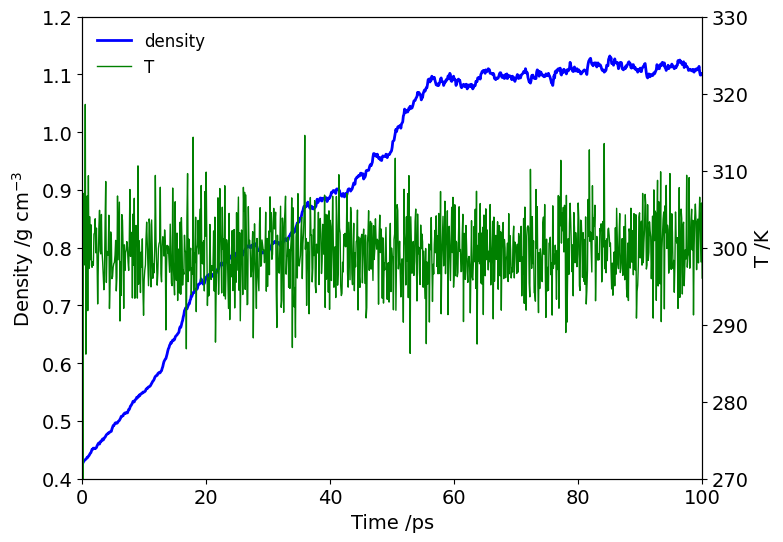

In [11]:
## check density
df = pd.read_csv('output/15C39H44O7_npt-eq_v6cU0d3-add.log', sep=',')

## set figure
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1, 1, 1)

## set plots
ax1.plot(df['time[ps]'], df['density[g/cm3]'], c='blue', linewidth = 2, label='density')
ax2 = ax1.twinx()
ax2.plot(df['time[ps]'], df['T[K]'], c='green', linewidth = 1, label='T')

## set plot format
ax1.set_xlabel("Time /ps", fontsize=14)
ax1.set_ylabel("Density /g cm$^{-3}$", fontsize=14)
ax1.set_xlim(0,100)
ax1.set_ylim(0.4,1.2)
ax1.tick_params(labelsize=14)
ax2.set_ylabel('T /K', fontsize=14)
ax2.set_ylim(270,330)
ax2.tick_params(labelsize=14)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()    
ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=12, frameon=False)

print(f'mean density(80-100 ps) = {df["density[g/cm3]"][-200:].mean():.3f}')

[JP]類似化合物の実験値と近い密度~1.1に収束している  
[EN]The density of the system converged to ~1.1 (near experimental value of a structally similar molecule).
- Bisphenol-A diglycidyl ether  
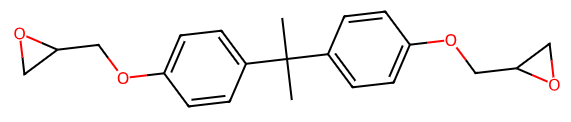  
density = 1.16 g/mL at 25 °C (lit.)  
https://www.sigmaaldrich.com/JP/ja/product/sigma/d3415  


In [12]:
# NVT-MD (20 ps, Berendsen thermostat at 300 K)
## set parameters NVT-MD
dirout = 'output'
sysname = '15C39H44O7'
fname = f'{sysname}_nvt-eq_{method}'
traj_path = f'{dirout}/{fname}.traj'
log_path = f'{dirout}/{fname}.log'
addlog_path = f'{dirout}/{fname}-add.log'
temp = 300.
dt = 1.0  ## 1 fs
steps = 20000  ## 20 ps
atoms = read('output/15C39H44O7_npt-eq_v6cU0d3.traj', index=-1)
atoms.calc = calculator

## set NVTBerendsen dynamics
dyn = NVTBerendsen(
    atoms=atoms, 
    timestep=dt * units.fs, 
    temperature_K=temp,
    taut=30 * units.fs,
    fixcm=True,
    trajectory=f'{traj_path}', 
    loginterval=100,
    )
dyn.attach(print_dyn, interval=100)
dyn.attach(MDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{log_path}', 
            header=True, stress=True, peratom=False, mode="w"), 
            interval=100
          )
dyn.attach(AddMDLogger(
            dyn=dyn, atoms=atoms, logfile=f'{addlog_path}', 
            header=False, mode="w"),
            interval=100
          ) 

## run MD
Stationary(atoms)
t_start = perf_counter()
dyn.run(steps)

Dyn  step:        0, time[ps]:    0.00, Etot[eV]:  -6586.3856, Epot[eV]:  -6638.0475, Ekin[eV]:   51.6619, T[K]:  296.06, density[g/cm3]: 1.101, calc_time[min]:     0.00
Dyn  step:      100, time[ps]:    0.10, Etot[eV]:  -6586.2645, Epot[eV]:  -6637.8719, Ekin[eV]:   51.6074, T[K]:  295.74, density[g/cm3]: 1.101, calc_time[min]:     0.45
Dyn  step:      200, time[ps]:    0.20, Etot[eV]:  -6586.1473, Epot[eV]:  -6638.9645, Ekin[eV]:   52.8173, T[K]:  302.68, density[g/cm3]: 1.101, calc_time[min]:     0.91
Dyn  step:      300, time[ps]:    0.30, Etot[eV]:  -6586.1753, Epot[eV]:  -6637.5190, Ekin[eV]:   51.3437, T[K]:  294.23, density[g/cm3]: 1.101, calc_time[min]:     1.36
Dyn  step:      400, time[ps]:    0.40, Etot[eV]:  -6585.8027, Epot[eV]:  -6638.2641, Ekin[eV]:   52.4615, T[K]:  300.64, density[g/cm3]: 1.101, calc_time[min]:     1.83
Dyn  step:      500, time[ps]:    0.50, Etot[eV]:  -6586.6401, Epot[eV]:  -6639.0046, Ekin[eV]:   52.3645, T[K]:  300.08, density[g/cm3]: 1.101, calc_

True

In [13]:
## check structure
atoms_tmp = read('output/15C39H44O7_nvt-eq_v6cU0d3.traj',index=-1)
get_mol_list(atoms_tmp)[0]
#view_ngl(get_mol_list(atoms_tmp)[0], representations=['ball+stick'], replace_structure=True)

[Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
 Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
 Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
 Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
 Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
 Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
 Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
 Atoms(symbols='C39H44O7', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], 

[JP]平衡化過程で意図しない化学反応は起こっていない  
[EN]No undesired chemical reactions occurred in the equilibration process.

## 3. [JP]熱分解シミュレーション
- 昇温速度違い（100, 250, 500 K/ps で 300 K から 2300 K まで）
- 到達温度違い（500 K/ps で 300 K から 2800, 3300, 4300 K まで）

## 3. [EN]Pyrolysis simulations
- Different heating rates（from 300 K to 2300 K by 100, 250, and 500 K/ps）
- Different target temperatures（from 300 K to 2800, 3300, 4300 K by 500 K/ps）

### [JP]昇温速度違い（100, 250, 500 K/ps で 300 K から 2300 K まで）
1) NVT-MD@昇温速度 100 K/ps, 300 K から 2300 K まで, 0.1 fs/step, 25 ps
2) NVT-MD@昇温速度 250 K/ps, 300 K から 2300 K まで, 0.1 fs/step, 25 ps
3) NVT-MD@昇温速度 500 K/ps, 300 K から 2300 K まで, 0.1 fs/step, 25 ps

### [EN]Different heating rates（from 300 K to 2300 K by 100, 250, and 500 K/ps）
1) NVT-MD@heating rate = 100 K/ps, from 300 K to 2300 K, 0.1 fs/step, 25 ps
2) NVT-MD@heating rate = 250 K/ps, from 300 K to 2300 K, 0.1 fs/step, 25 ps
3) NVT-MD@heating rate = 500 K/ps, from 300 K to 2300 K, 0.1 fs/step, 25 ps

In [14]:
## set NVT-MD print&logger
class PrintWriteLog(MDExtensionBase):
    def __init__(self, fname, dirout='.', stdout=False):
        self.fname   = fname
        self.dirout  = dirout
        self.t_start = perf_counter()
        self.stdout  = stdout
        
    def __call__(self, system, integrator):
        n_step    = system.current_total_step
        sim_time  = system.current_total_time /1000  ## ps
        E_tot     = system.ase_atoms.get_total_energy()
        E_pot     = system.ase_atoms.get_potential_energy()
        E_kin     = system.ase_atoms.get_kinetic_energy()
        temp      = system.ase_atoms.get_temperature()
        density   = system.ase_atoms.get_masses().sum()/units.mol / (system.ase_atoms.cell.volume*(1e-8**3))
        calc_time = (perf_counter() - self.t_start) / 60.  ## min.

        ## write header
        if n_step == 0:
            hdr  = 'step,time[ps],E_tot[eV],E_pot[eV],E_kin[eV],'
            hdr += 'T[K],density[g/cm3],calc_time[min]'
            with open(f'{self.dirout}/{self.fname}.log', 'w') as f_log:
                f_log.write(f'{hdr}\n')
                
        ## write&print result
        line  = f'{n_step:8d},{sim_time:7.2f},'
        line += f'{E_tot:11.4f},{E_pot:11.4f},{E_kin:9.4f},'
        line += f'{temp:8.2f},{density:7.3f},{calc_time:8.2f}'
        with open(f'{self.dirout}/{self.fname}.log', 'a') as f_log:
            f_log.write(f'{line}\n')
        if self.stdout:
            print(line)

In [15]:
## MD with TempSchedular
def pyrolysis_md(md_params):
    ## set pfp_estimator_fn
    estimator_fn = pfp_estimator_fn(
        model_version=md_params['model_version'], 
        calc_mode=md_params['calc_mode'], 
        )

    ## set system
    system = ASEMDSystem(
        atoms=md_params['atoms'],
        step=0,
        time=0.0,
        )

    ## set integrator
    integrator = NVTBerendsenIntegrator(
        timestep=md_params['timestep'],
        temperature=md_params['temp_start'],
        taut=100.,  ## 100 fs (same as the reference)
        fixcm=True,
        )
    
    ## set MD feature
    md = MDFeature(
        integrator=integrator,
        n_run=md_params['n_run'],
        show_progress_bar=False,
        show_logger=False,
        logger_interval=md_params['logger_interval'],
        estimator_fn=estimator_fn,
        traj_file_name=f"{md_params['dirout']}/{md_params['fname']}.traj",
        traj_freq=md_params['traj_freq'],  ## Trajectory saving frequency
        )

    ## set chedular for temperature rising (as md_extensions)
    step_ext = int( (md_params['temp_target']-md_params['temp_start'])/md_params['kelvin_per_ps']*1000/md_params['timestep'] )  ## temporary
    TempSchedular = TemperatureScheduler(
        start_value=md_params['temp_start'], 
        end_value=md_params['temp_target'],
        num_total_steps=step_ext,  ## Number of steps for the linear temperature change
        )

    ## perform MD simulations with previous settings
    md_results = md(
        system=system,
        extensions=[(TempSchedular, 1), 
                    (PrintWriteLog(fname=md_params['fname'],dirout=md_params['dirout']), md_params['logger_interval'])
                   ]
        )

In [16]:
## set MD parameter list
dirout = 'output'
sysname = '15C39H44O7'
atoms = read(f'{dirout}/{sysname}_nvt-eq_v6cU0d3.traj', index=-1)
temp_rate_target = [
    [100, 2300],  ## 100 K/ps, 2300 K
    [250, 2300],  ## 250 K/ps, 2300 K
    [500, 2300],  ## 500 K/ps, 2300 K
]
jobparam_list = []
for kelvin_per_ps, temp_target in temp_rate_target:
    md_params = {
        'model_version': 'v6.0.0', 
        'calc_mode': 'CRYSTAL_U0_PLUS_D3', 
        "atoms": atoms.copy(),
        "timestep": 0.1,  ## fs
        "temp_start": 300,
        "temp_target": temp_target,
        "n_run": 250000,
        "logger_interval": 500,
        "traj_freq": 500,
        "kelvin_per_ps": kelvin_per_ps,
        "dirout": dirout
        }
    tot_ps = int(md_params['n_run'] * md_params['timestep'] / 1000)
    md_params["fname"] = f'{sysname}_nvt-prod_{temp_target}K-{kelvin_per_ps}Kps-{tot_ps}ps'
    jobparam_list.append(md_params)
jobparam_list

[{'model_version': 'v6.0.0',
  'calc_mode': 'CRYSTAL_U0_PLUS_D3',
  'atoms': Atoms(symbols='C585H660O105', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
  'timestep': 0.1,
  'temp_start': 300,
  'temp_target': 2300,
  'n_run': 250000,
  'logger_interval': 500,
  'traj_freq': 500,
  'kelvin_per_ps': 100,
  'dirout': 'output',
  'fname': '15C39H44O7_nvt-prod_2300K-100Kps-25ps'},
 {'model_version': 'v6.0.0',
  'calc_mode': 'CRYSTAL_U0_PLUS_D3',
  'atoms': Atoms(symbols='C585H660O105', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
  'timestep': 0.1,
  'temp_start': 300,
  'temp_target': 2300,
  'n_run': 250000,
  'logger_interval': 500,
  'traj_freq': 500,
  'kelvin_per_ps': 250,
  'dirout': 'output',
  'fname': '15C39H44O7_nvt-prod_2300K-250Kps-25ps'},
 {'model_version': 'v6.0.0',
  'calc_mode': 'CRYSTAL_U0_PLUS_D3',
  'atoms': Atoms(symbols='C585H660O105', pbc=True, cell=[31.6863

In [17]:
## run MD (-15 hours each)
Parallel(n_jobs=3, backend="threading", verbose=1)(
    delayed(pyrolysis_md)(md_params) for md_params in jobparam_list
    )

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
The MD trajectory will be saved at /home/jovyan/work/epoxy_pyrolysis/output/15C39H44O7_nvt-prod_2300K-100Kps-25ps.traj.
Note: The max disk size of /home/jovyan is about 99G.
The MD trajectory will be saved at /home/jovyan/work/epoxy_pyrolysis/output/15C39H44O7_nvt-prod_2300K-250Kps-25ps.traj.
Note: The max disk size of /home/jovyan is about 99G.
The MD trajectory will be saved at /home/jovyan/work/epoxy_pyrolysis/output/15C39H44O7_nvt-prod_2300K-500Kps-25ps.traj.
Note: The max disk size of /home/jovyan is about 99G.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 1404.8min finished


[None, None, None]

### [JP]到達温度違い（500 K/ps で 300 K から 2800, 3300, 4300 K まで）
1) NVT-MD@昇温速度 500 K/ps, 300 K から 2800 K まで, 0.1 fs/step, 25 ps
2) NVT-MD@昇温速度 500 K/ps, 300 K から 3300 K まで, 0.1 fs/step, 25 ps
3) NVT-MD@昇温速度 500 K/ps, 300 K から 4300 K まで, 0.1 fs/step, 25 ps

### [EN]Different target temperatures（from 300 K to 2800, 3300, 4300 K by 500 K/ps）
1) NVT-MD@heating rate = 500 K/ps, from 300 K to 2800 K, 0.1 fs/step, 25 ps
2) NVT-MD@heating rate = 500 K/ps, from 300 K to 3300 K, 0.1 fs/step, 25 ps
3) NVT-MD@heating rate = 500 K/ps, from 300 K to 4300 K, 0.1 fs/step, 25 ps

In [18]:
## set MD parameter list
dirout = 'output'
sysname = '15C39H44O7'
atoms = read(f'{dirout}/{sysname}_nvt-eq_v6cU0d3.traj', index=-1)
temp_rate_target = [
    [500, 2800],  ## 500 K/ps, 2800 K
    [500, 3300],  ## 500 K/ps, 3300 K
    [500, 4300],  ## 500 K/ps, 4300 K
]
jobparam_list = []
for kelvin_per_ps, temp_target in temp_rate_target:
    md_params = {
        'model_version': 'v6.0.0', 
        'calc_mode': 'CRYSTAL_U0_PLUS_D3', 
        "atoms": atoms.copy(),
        "timestep": 0.1,  ## fs
        "temp_start": 300,
        "temp_target": temp_target,
        "n_run": 250000,
        "logger_interval": 500,
        "traj_freq": 500,
        "kelvin_per_ps": kelvin_per_ps,
        "dirout": dirout
        }
    tot_ps = int(md_params['n_run'] * md_params['timestep'] / 1000)
    md_params["fname"] = f'{sysname}_nvt-prod_{temp_target}K-{kelvin_per_ps}Kps-{tot_ps}ps'
    jobparam_list.append(md_params)
jobparam_list

[{'model_version': 'v6.0.0',
  'calc_mode': 'CRYSTAL_U0_PLUS_D3',
  'atoms': Atoms(symbols='C585H660O105', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
  'timestep': 0.1,
  'temp_start': 300,
  'temp_target': 2800,
  'n_run': 250000,
  'logger_interval': 500,
  'traj_freq': 500,
  'kelvin_per_ps': 500,
  'dirout': 'output',
  'fname': '15C39H44O7_nvt-prod_2800K-500Kps-25ps'},
 {'model_version': 'v6.0.0',
  'calc_mode': 'CRYSTAL_U0_PLUS_D3',
  'atoms': Atoms(symbols='C585H660O105', pbc=True, cell=[31.686357020733265, 21.124238013822207, 21.124238013822207], momenta=..., tags=...),
  'timestep': 0.1,
  'temp_start': 300,
  'temp_target': 3300,
  'n_run': 250000,
  'logger_interval': 500,
  'traj_freq': 500,
  'kelvin_per_ps': 500,
  'dirout': 'output',
  'fname': '15C39H44O7_nvt-prod_3300K-500Kps-25ps'},
 {'model_version': 'v6.0.0',
  'calc_mode': 'CRYSTAL_U0_PLUS_D3',
  'atoms': Atoms(symbols='C585H660O105', pbc=True, cell=[31.6863

In [19]:
## run MD (-15 hours each)
Parallel(n_jobs=3, backend="threading", verbose=1)(
    delayed(pyrolysis_md)(md_params) for md_params in jobparam_list
    )

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
The MD trajectory will be saved at /home/jovyan/work/epoxy_pyrolysis/output/15C39H44O7_nvt-prod_3300K-500Kps-25ps.traj.
Note: The max disk size of /home/jovyan is about 99G.
The MD trajectory will be saved at /home/jovyan/work/epoxy_pyrolysis/output/15C39H44O7_nvt-prod_2800K-500Kps-25ps.traj.
Note: The max disk size of /home/jovyan is about 99G.
The MD trajectory will be saved at /home/jovyan/work/epoxy_pyrolysis/output/15C39H44O7_nvt-prod_4300K-500Kps-25ps.traj.
Note: The max disk size of /home/jovyan is about 99G.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 1422.2min finished


[None, None, None]

## 4. [JP]トラジェクトリー解析
- 熱分解シミュレーションで生成した小分子のフラグメントをカウント("get_mol_list")  
1) 昇温速度違い（元論文 Fig. 4）  
2) 到達温度違い（元論文 Fig. 5）

## 4. [EN]Trajectory analysis
- Counting small molecules generated in the pyrolysis simulations ("get_mol_list")  
1) Different heating rates (Fig. 4 in the original paper)
2) Different target temperatures (Fig. 5 in the original paper)

### [JP]昇温速度違い（元論文 Fig. 4）/ Different heating rates (Fig. 4 in the original paper)

In [20]:
## count fragments & return resulting dataframe (get_mol_list)
def count_fragms(l_atoms, ref_fragm):
    for idx, atoms in enumerate(l_atoms):
        d_formula = dict(zip(ref_fragm, np.zeros(len(ref_fragm), dtype=int)))
        d_formula['time[ps]'] = idx * 0.1 * 500 / 1000  ## ps
        d_formula['T[K]'] = atoms.get_temperature()

        l_fragm_atoms = get_mol_list(atoms)[0]
        d_count = Counter([x.get_chemical_formula() for x in l_fragm_atoms])
        for fragm in ref_fragm:
            d_formula[fragm] = d_count[fragm]
            
        if idx == 0:
            df = pd.DataFrame(d_formula, index=[idx])
        else:
            df = pd.concat([df, pd.DataFrame(d_formula, index=[idx])])
    return df

In [21]:
## set traj files
l_ftraj_path = [
    'output/15C39H44O7_nvt-prod_2300K-100Kps-25ps.traj',
    'output/15C39H44O7_nvt-prod_2300K-250Kps-25ps.traj',
    'output/15C39H44O7_nvt-prod_2300K-500Kps-25ps.traj',
]
atoms_ini = read('output/15C39H44O7_nvt-eq_v6cU0d3.traj',index=-1)

## set chemical formulas of fragments listed up in the original paper
ref_fragm = ["C39H44O7",  ## original epoxy
           "CH2O",
           "CO",
           "H2O",
           "H2",
           "CH4"
          ]

## get results (~15 min.)
l_rate_df = []
for ftraj in l_ftraj_path:
    l_atoms = [atoms_ini] + read(ftraj, index=':')
    df = count_fragms(l_atoms, ref_fragm)
    l_rate_df.append(df)

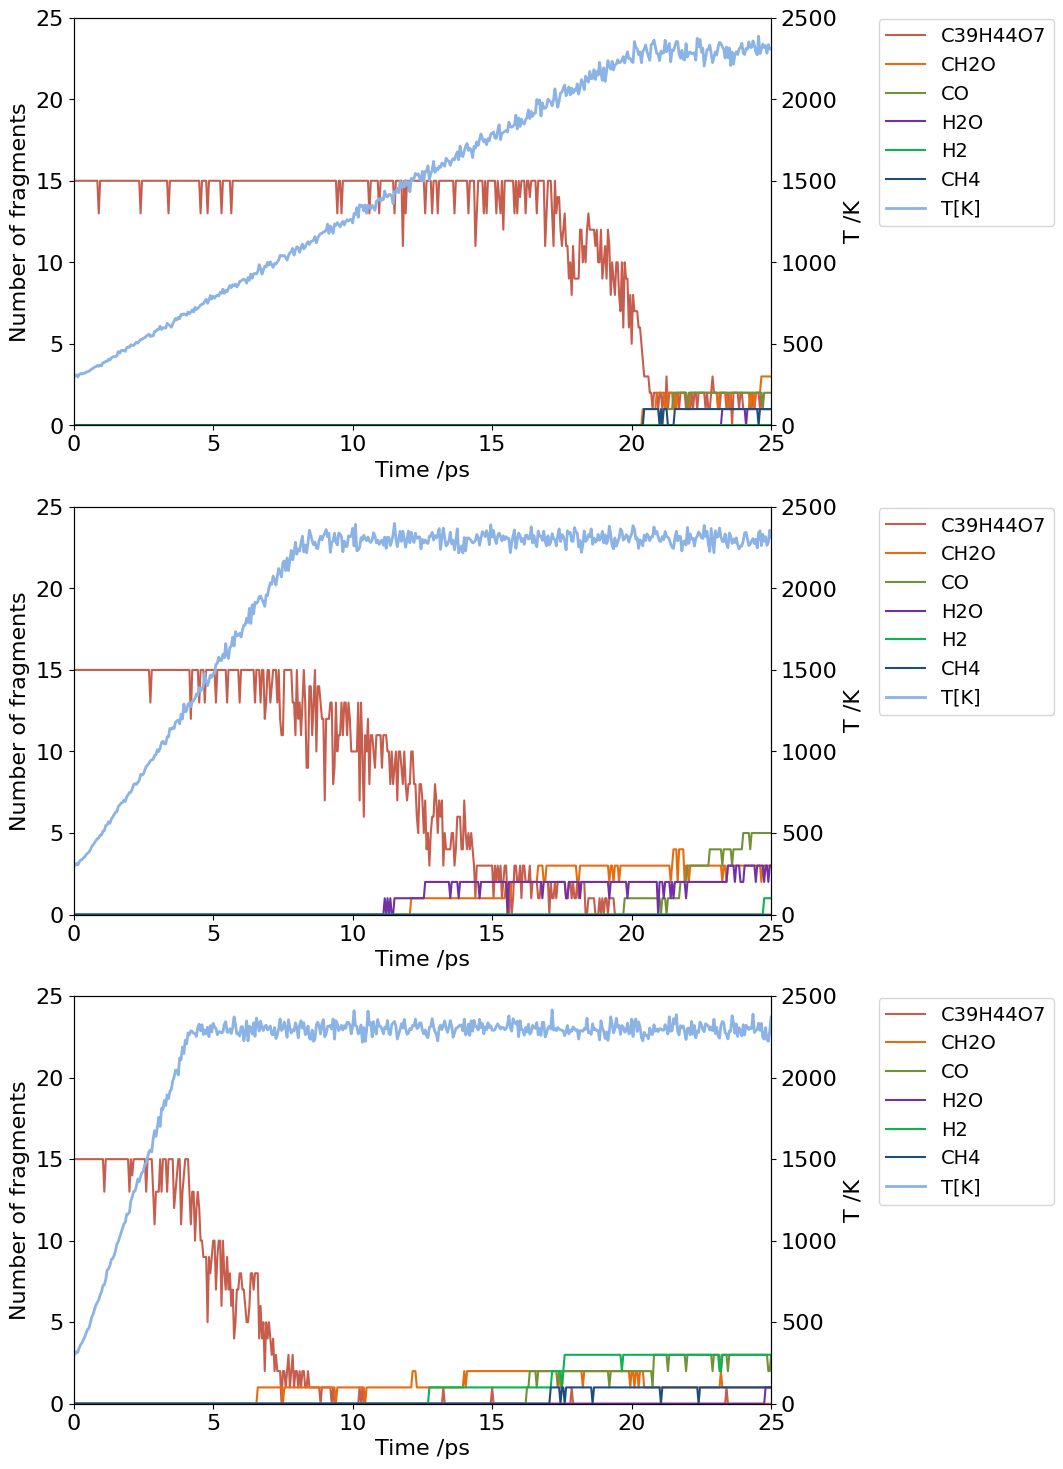

In [22]:
## plot result
fig = plt.figure(figsize=(9,18))

## set fig
for idx, df in enumerate(l_rate_df,1):
    ax1 = fig.add_subplot(len(l_rate_df),1,idx)
    ax2 = ax1.twinx()

    ## plot
    ax1.plot(df['time[ps]'], df['C39H44O7'], label = "C39H44O7", c='#C65D4D')
    ax1.plot(df['time[ps]'], df['CH2O'], label = "CH2O", c='#E66D0F')
    ax1.plot(df['time[ps]'], df['CO'], label = "CO", c='#729238')
    ax1.plot(df['time[ps]'], df['H2O'], label = "H2O", c='#7230A4')
    ax1.plot(df['time[ps]'], df['H2'], label = "H2", c='#0AB450')
    ax1.plot(df['time[ps]'], df['CH4'], label = "CH4", c='#1E4E7E')
    ax2.plot(df['time[ps]'], df['T[K]'], label = "T[K]", linewidth = 2, c='#8BB3E5')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()    

    ## format
    ax1.set_xlabel("Time /ps", fontsize=16)
    ax1.set_ylabel("Number of fragments", fontsize=16)
    ax2.set_ylabel("T /K", fontsize=16)
    ax1.set_xlim(0,25)
    ax1.set_ylim(0,25)
    ax2.set_ylim(0,2500)
    ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=14, bbox_to_anchor=(1.14, 1.02))
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    
fig.savefig('output/heatingrate_dependency.png', bbox_inches='tight',)

### [JP]到達温度違い（元論文 Fig. 5）/ [EN]Different target temperatures (Fig. 5 in the original paper)

In [23]:
## read structures
l_traj_path = [
    'output/15C39H44O7_nvt-prod_2800K-500Kps-25ps.traj',
    'output/15C39H44O7_nvt-prod_3300K-500Kps-25ps.traj',
    'output/15C39H44O7_nvt-prod_4300K-500Kps-25ps.traj',
]
atoms_ini = read('output/15C39H44O7_nvt-eq_v6cU0d3.traj',index=-1)

## set chemical formulas of fragments listed up in the original paper
ref_fragm = ["C39H44O7",  ## original epoxy
           "CH2O",
           "CO",
           "H2O",
           "H2",
           "CH4"
          ]

## get results (dataframe)
l_temp_df = []
for traj in l_traj_path:
    l_atoms = [atoms_ini] + read(traj, index=':')
    df = count_fragms(l_atoms, ref_fragm)
    l_temp_df.append(df)

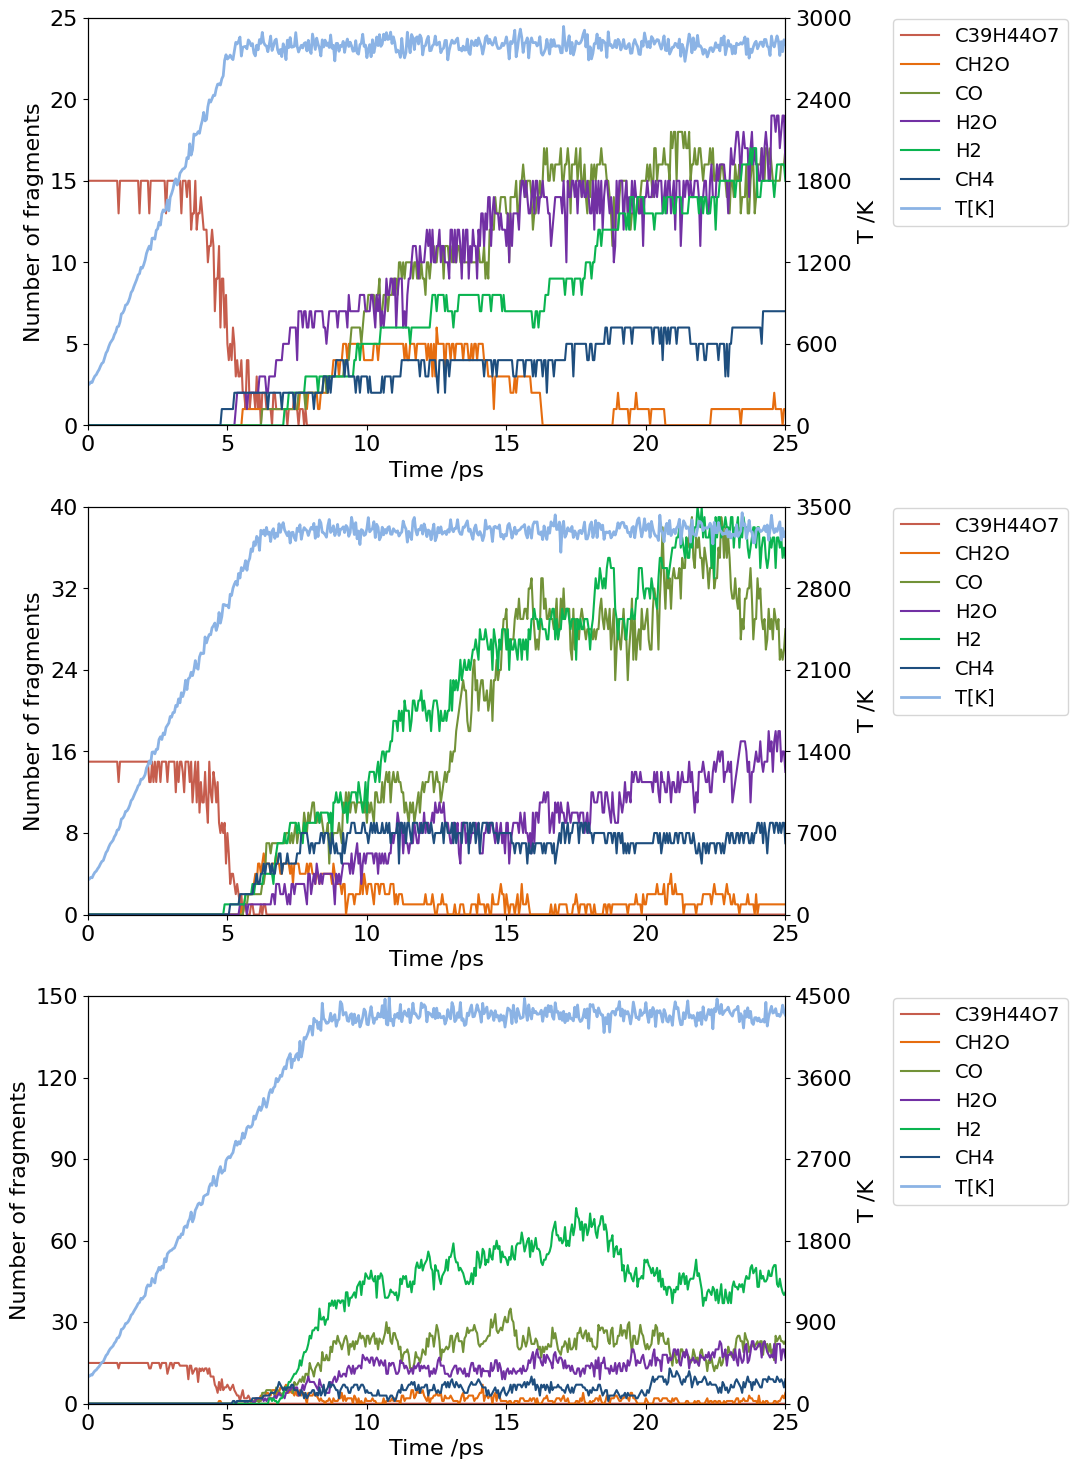

In [24]:
## plot result
l_ylim = [
    [25, 3000],
    [40, 3500],
    [150, 4500],
]

fig = plt.figure(figsize=(9,18))
idx = 0

## set fig
for ylim, df in zip(l_ylim, l_temp_df):
    idx += 1
    ax1 = fig.add_subplot(len(l_ylim),1,idx)
    ax2 = ax1.twinx()

    ## plot
    ax1.plot(df['time[ps]'], df['C39H44O7'], label = "C39H44O7", c='#C65D4D')
    ax1.plot(df['time[ps]'], df['CH2O'], label = "CH2O", c='#E66D0F')
    ax1.plot(df['time[ps]'], df['CO'], label = "CO", c='#729238')
    ax1.plot(df['time[ps]'], df['H2O'], label = "H2O", c='#7230A4')
    ax1.plot(df['time[ps]'], df['H2'], label = "H2", c='#0AB450')
    ax1.plot(df['time[ps]'], df['CH4'], label = "CH4", c='#1E4E7E')
    ax2.plot(df['time[ps]'], df['T[K]'], label = "T[K]", linewidth = 2, c='#8BB3E5')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()    

    ## format
    ax1.set_xlabel("Time /ps", fontsize=16)
    ax1.set_ylabel("Number of fragments", fontsize=16)
    ax2.set_ylabel("T /K", fontsize=16)
    ax1.set_xlim(0,25)
    ax1.set_ylim(0,ylim[0])
    ax1.set_yticks(np.arange(0, ylim[0]+1, step=ylim[0]/5))
    ax2.set_ylim(0,ylim[1])
    ax2.set_yticks(np.arange(0, ylim[1]+1, step=ylim[1]/5))
    ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=14, bbox_to_anchor=(1.14, 1.02))
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)

fig.savefig('output/temperature_dependency.png', bbox_inches='tight',)